<a href="https://colab.research.google.com/github/LeoFernanndes/portfolio/blob/master/ChicagoTaxiRidePrice_parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

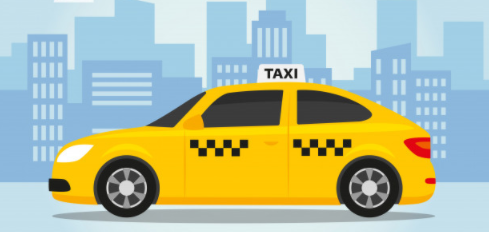

# Chicago Taxi Ride Price Regression pt. 2

In [1]:
!pip install haversine # biblioteca usada para calcular distâncias baseadas em coordenadas

In [2]:
import pandas as pd


pd.options.display.max_rows = 50

url = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/chicago_taxi_sample_50k.csv'
df_taxi = pd.read_csv(url)

df_baseline = df_taxi.copy()
df_baseline.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,ride_date
0,d3c594ba6b3eb5f9644b9af3f1328aa82744ffd5,a0ac953f8cee6f14d8f2f15bf14b52de5caab289f7d599...,2019-09-13 23:00:00+00:00,2019-09-13 23:00:00+00:00,60.0,0.0,NaN,NaN,7.0,7.0,3.25,0.0,0.0,0.0,3.25,Cash,Taxi Affiliation Services,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),2019-09-13
1,cac1926e5b4ca977decbf9079ffd4b02cae90503,b5e2695a2f44b9bce7a0a86148ac418802f0067be1f6d4...,2014-06-19 18:00:00+00:00,2014-06-19 18:15:00+00:00,840.0,2.3,NaN,NaN,24.0,8.0,9.85,2.0,0.0,0.0,11.85,Credit Card,NaN,41.901207,-87.676356,POINT (-87.6763559892 41.90120699410001),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),2014-06-19
2,ab1adf76a077d31a82824264aed032f197423f5d,41afbb1073e9c58a6dbdfff8ad24160d01c862ca34c520...,2018-08-24 16:00:00+00:00,2018-08-24 16:45:00+00:00,3180.0,0.9,1.703198e+10,1.703108e+10,76.0,8.0,41.00,9.2,0.0,5.0,55.20,Credit Card,Taxi Affiliation Services,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.907413,-87.640902,POINT (-87.6409015248 41.9074128162),2018-08-24
3,d19b9b5131a749b6c8fee6661a84833421c1e25f,6daab772b2fe0e6dcb68884525d6ad9d44ce74ecaeb417...,2015-06-20 12:15:00+00:00,2015-06-20 12:30:00+00:00,540.0,2.9,1.703108e+10,1.703107e+10,8.0,7.0,9.44,2.0,0.0,0.0,11.44,Credit Card,NaN,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.929263,-87.635891,POINT (-87.6358909539 41.9292629902),2015-06-20
4,48262d526cc41442f947b81a3ab0f60174fc66cc,11f73b08790612efe341cf8cf69cadbcb7732293794186...,2018-08-10 21:00:00+00:00,2018-08-10 21:00:00+00:00,600.0,1.6,1.703128e+10,1.703108e+10,28.0,8.0,7.50,1.5,0.0,0.0,9.00,Credit Card,Choice Taxi Association,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),2018-08-10


## O que vamos ver aqui?

Lá na primeira parte dessa análise, nós vimos algumas manipulações que podem ser feitas pra ajudar a reduzir os erros na previsão dos preços das corridas. Previsão talvez não seja a melhor palvra ja que o que estamos fazendo aqui é na verdade uma interpolação, mas pra termos gerais, previsão vai atender bem.

Aqui, o trabalho vai ser um pouco mais focado no esforço de feature engineering. Como vimos no notebook anterior, mesmo sem entender nada do mercado de corridas de taxi, sabemos que para prever preços de corridas, o identificador do carro não tem relevância nenhuma. Pior, esse tipo de variável insignificante pode até reduzir a qualidade do modelo porque ele pode tentar descobrir uma relação entre os identificadores e o preço da corrida e introduzir ruído com isso.

Nessa parte da análise vamos ver:
1. Como lidar com dados faltantes 
2. Como lidar com outliers
3. Como codificar variáveis categóricas
4. Como extrair informação implícita nas variáveis
5. Como encotrar informação externa ao nosso dataset
6. Como avaliar se uma variável tem relação com o valor a ser previsto 
7. Como selecionar o melhor conjunto de variáveis


## 1. Manipulação de dados faltantes

#### Grosso modo, quando temos dados faltantes as alternativas são: 
1. Excluir a linha inteira que contenha ao menos uma variável nula
2. Usar alguma estratégia pra preencher esse valores.


In [3]:
# checando variáveis com valore nulos
# df_baseline.isnull().sum() # sem ordenação
print(f'Numero de linhas: {df_baseline.shape[0]}')
df_baseline.isnull().sum().sort_values(ascending=False) # ordenado

Numero de linhas: 50000


dropoff_census_tract      17429
pickup_census_tract       17213
company                    8719
tolls                      8428
dropoff_community_area     6799
dropoff_longitude          6662
dropoff_latitude           6662
dropoff_location           6662
pickup_community_area      5883
pickup_location            5878
pickup_longitude           5878
pickup_latitude            5878
trip_seconds                325
trip_end_timestamp            9
tips                          2
fare                          2
trip_total                    2
taxi_id                       2
extras                        2
trip_start_timestamp          0
ride_date                     0
trip_miles                    0
payment_type                  0
unique_key                    0
dtype: int64

#### 1.1. Simplesmente jogar fora os registros com dados incompletos:

In [4]:
df_baseline_dropna = df_baseline.dropna()
print(f'Número de linhas: {df_baseline_dropna.shape[0]}')
df_baseline_dropna.isnull().sum()

Número de linhas: 21638


unique_key                0
taxi_id                   0
trip_start_timestamp      0
trip_end_timestamp        0
trip_seconds              0
trip_miles                0
pickup_census_tract       0
dropoff_census_tract      0
pickup_community_area     0
dropoff_community_area    0
fare                      0
tips                      0
tolls                     0
extras                    0
trip_total                0
payment_type              0
company                   0
pickup_latitude           0
pickup_longitude          0
pickup_location           0
dropoff_latitude          0
dropoff_longitude         0
dropoff_location          0
ride_date                 0
dtype: int64

Os valores nulos sumiram, mas note que o tamanho do dataset diminuiu significativamente de 50k pra algo perto de 22k

#### 1.2. Preencher os valores faltantes com alguma estratégia

Aqui temos algumas opções:
1. Preencher todos os valores faltantes com algum indicativo que são nulos
2. Preencher os dados faltantes com valores presentes nas próprias colunas
3. Prencher os valores faltantes com valores presentes na propria coluna, mas agrupados com base em outras


1.2.1. Preencher todos os valores faltantes com algum indicativo de que são nulos

In [5]:
df_baseline_fillna_nulo = df_baseline.fillna('_Nulo')  
df_baseline_fillna_nulo.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,ride_date
0,d3c594ba6b3eb5f9644b9af3f1328aa82744ffd5,a0ac953f8cee6f14d8f2f15bf14b52de5caab289f7d599...,2019-09-13 23:00:00+00:00,2019-09-13 23:00:00+00:00,60,0.0,_Nulo,_Nulo,7,7,3.25,0,0,0,3.25,Cash,Taxi Affiliation Services,41.9227,-87.6495,POINT (-87.6494887289 41.9226862843),41.9227,-87.6495,POINT (-87.6494887289 41.9226862843),2019-09-13
1,cac1926e5b4ca977decbf9079ffd4b02cae90503,b5e2695a2f44b9bce7a0a86148ac418802f0067be1f6d4...,2014-06-19 18:00:00+00:00,2014-06-19 18:15:00+00:00,840,2.3,_Nulo,_Nulo,24,8,9.85,2,0,0,11.85,Credit Card,_Nulo,41.9012,-87.6764,POINT (-87.6763559892 41.90120699410001),41.8996,-87.6333,POINT (-87.6333080367 41.899602111),2014-06-19
2,ab1adf76a077d31a82824264aed032f197423f5d,41afbb1073e9c58a6dbdfff8ad24160d01c862ca34c520...,2018-08-24 16:00:00+00:00,2018-08-24 16:45:00+00:00,3180,0.9,1.7032e+10,1.70311e+10,76,8,41,9.2,0,5,55.2,Credit Card,Taxi Affiliation Services,41.9791,-87.903,POINT (-87.9030396611 41.9790708201),41.9074,-87.6409,POINT (-87.6409015248 41.9074128162),2018-08-24
3,d19b9b5131a749b6c8fee6661a84833421c1e25f,6daab772b2fe0e6dcb68884525d6ad9d44ce74ecaeb417...,2015-06-20 12:15:00+00:00,2015-06-20 12:30:00+00:00,540,2.9,1.70311e+10,1.70311e+10,8,7,9.44,2,0,0,11.44,Credit Card,_Nulo,41.8925,-87.6262,POINT (-87.6262149064 41.8925077809),41.9293,-87.6359,POINT (-87.6358909539 41.9292629902),2015-06-20
4,48262d526cc41442f947b81a3ab0f60174fc66cc,11f73b08790612efe341cf8cf69cadbcb7732293794186...,2018-08-10 21:00:00+00:00,2018-08-10 21:00:00+00:00,600,1.6,1.70313e+10,1.70311e+10,28,8,7.5,1.5,0,0,9,Credit Card,Choice Taxi Association,41.8793,-87.6426,POINT (-87.642648998 41.8792550844),41.892,-87.6319,POINT (-87.6318639497 41.8920421365),2018-08-10


Da pra ver que apareceram alguns valores "_Nulo" por aí. A parte boa é que o dataframe segue com os 50k registros, mas a parte ruim é que esse tipo de imputação transforma colunas numéricas com valores nulos em colunas categóricas pois agora têm a string "_Nulos" nelas. É o caso por exemplo de pickup_census_tract

2. Preencher os dados faltantes com valores presentes nas próprias colunas

In [6]:
# primeiro vamos observar os tipos de cada variável
df_baseline.dtypes

unique_key                 object
taxi_id                    object
trip_start_timestamp       object
trip_end_timestamp         object
trip_seconds              float64
trip_miles                float64
pickup_census_tract       float64
dropoff_census_tract      float64
pickup_community_area     float64
dropoff_community_area    float64
fare                      float64
tips                      float64
tolls                     float64
extras                    float64
trip_total                float64
payment_type               object
company                    object
pickup_latitude           float64
pickup_longitude          float64
pickup_location            object
dropoff_latitude          float64
dropoff_longitude         float64
dropoff_location           object
ride_date                  object
dtype: object

In [7]:
df_baseline_fillna_valores_colunas = df_baseline.copy()
for column in  df_baseline_fillna_valores_colunas.columns: # pra cada coluna no dataframe
  if df_baseline_fillna_valores_colunas[column].dtype == "object": # se o tipo da coluna for object (pro nosso caso basta saber que não é numérica)
    df_baseline_fillna_valores_colunas[column].fillna(df_baseline_fillna_valores_colunas[column].mode()[0], inplace=True) # preenche os nulos com a primeira moda da coluna
  else: # pra todos os outros tipos de dados
    df_baseline_fillna_valores_colunas[column].fillna(df_baseline_fillna_valores_colunas[column].median(), inplace=True) # preenche com a mediana da coluna

df_baseline_fillna_valores_colunas.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,ride_date
0,d3c594ba6b3eb5f9644b9af3f1328aa82744ffd5,a0ac953f8cee6f14d8f2f15bf14b52de5caab289f7d599...,2019-09-13 23:00:00+00:00,2019-09-13 23:00:00+00:00,60.0,0.0,1.703128e+10,1.703128e+10,7.0,7.0,3.25,0.0,0.0,0.0,3.25,Cash,Taxi Affiliation Services,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),2019-09-13
1,cac1926e5b4ca977decbf9079ffd4b02cae90503,b5e2695a2f44b9bce7a0a86148ac418802f0067be1f6d4...,2014-06-19 18:00:00+00:00,2014-06-19 18:15:00+00:00,840.0,2.3,1.703128e+10,1.703128e+10,24.0,8.0,9.85,2.0,0.0,0.0,11.85,Credit Card,Taxi Affiliation Services,41.901207,-87.676356,POINT (-87.6763559892 41.90120699410001),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),2014-06-19
2,ab1adf76a077d31a82824264aed032f197423f5d,41afbb1073e9c58a6dbdfff8ad24160d01c862ca34c520...,2018-08-24 16:00:00+00:00,2018-08-24 16:45:00+00:00,3180.0,0.9,1.703198e+10,1.703108e+10,76.0,8.0,41.00,9.2,0.0,5.0,55.20,Credit Card,Taxi Affiliation Services,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.907413,-87.640902,POINT (-87.6409015248 41.9074128162),2018-08-24
3,d19b9b5131a749b6c8fee6661a84833421c1e25f,6daab772b2fe0e6dcb68884525d6ad9d44ce74ecaeb417...,2015-06-20 12:15:00+00:00,2015-06-20 12:30:00+00:00,540.0,2.9,1.703108e+10,1.703107e+10,8.0,7.0,9.44,2.0,0.0,0.0,11.44,Credit Card,Taxi Affiliation Services,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.929263,-87.635891,POINT (-87.6358909539 41.9292629902),2015-06-20
4,48262d526cc41442f947b81a3ab0f60174fc66cc,11f73b08790612efe341cf8cf69cadbcb7732293794186...,2018-08-10 21:00:00+00:00,2018-08-10 21:00:00+00:00,600.0,1.6,1.703128e+10,1.703108e+10,28.0,8.0,7.50,1.5,0.0,0.0,9.00,Credit Card,Choice Taxi Association,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),2018-08-10


Aqui, a vantagem é que mantemos o tipo de cada coluna. A desvantagem é que esse tipo de estratégia de imputação baseada nos valores de outros registros insere uma informação que a gente não pode "confiar 100%" ja que não é real

Aqui temos uma parcepção vai ser presente em todo o trabalho de inputação de variáveis: vai sempre existir um trade off entre manter a informação mais verdadeira o possível ao custo de reduzir o tamanho do dataser ou manter o volume de dados, mas com um certo grau de incerteza sobre esse número maior de registros. 

3. Prencher os valores faltantes com valores presentes na propria coluna, mas agrupados com base em outras

Imagine que tenhamos um conjunto de dados de carros de carros usados com valores de quilometragem faltantes. Parece muito mais preciso preencher os valores com base nos anos de uso do carro do que com as informações da coluna quilometragem de forma genérica.

Aqui no dataset de corridas de taxi, não vejo muito sentido em fazer algo assim, mas vamos ver um exemplo só pra praticar.

Vamos preencher os dados da coluna company que tem 8719 dados faltantes com base na companhia que mais fez corridas naquele dia.

In [8]:
def imputation(serie):
  return serie.fillna(serie.mode()[0])

df_baseline_fillna_valores_outras = df_baseline.copy()
# df_baseline_fillna_valores_outras['company'] = df_baseline_fillna_valores_outras.groupby(by=['ride_date'])['company'].apply(imputation) # também da pra fazer assim, sem a passagem do parametro serie, mas a função lambda é bem mais legível
df_baseline_fillna_valores_outras['company'] = df_baseline_fillna_valores_outras.groupby(by=['ride_date'])['company'].apply(lambda x: x.fillna(x.mode()[0])) # x nesse caso, é a série formada pra cada dia na coluna ride_date
df_baseline_fillna_valores_outras.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,ride_date
0,d3c594ba6b3eb5f9644b9af3f1328aa82744ffd5,a0ac953f8cee6f14d8f2f15bf14b52de5caab289f7d599...,2019-09-13 23:00:00+00:00,2019-09-13 23:00:00+00:00,60.0,0.0,NaN,NaN,7.0,7.0,3.25,0.0,0.0,0.0,3.25,Cash,Taxi Affiliation Services,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),2019-09-13
1,cac1926e5b4ca977decbf9079ffd4b02cae90503,b5e2695a2f44b9bce7a0a86148ac418802f0067be1f6d4...,2014-06-19 18:00:00+00:00,2014-06-19 18:15:00+00:00,840.0,2.3,NaN,NaN,24.0,8.0,9.85,2.0,0.0,0.0,11.85,Credit Card,Taxi Affiliation Services,41.901207,-87.676356,POINT (-87.6763559892 41.90120699410001),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),2014-06-19
2,ab1adf76a077d31a82824264aed032f197423f5d,41afbb1073e9c58a6dbdfff8ad24160d01c862ca34c520...,2018-08-24 16:00:00+00:00,2018-08-24 16:45:00+00:00,3180.0,0.9,1.703198e+10,1.703108e+10,76.0,8.0,41.00,9.2,0.0,5.0,55.20,Credit Card,Taxi Affiliation Services,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.907413,-87.640902,POINT (-87.6409015248 41.9074128162),2018-08-24
3,d19b9b5131a749b6c8fee6661a84833421c1e25f,6daab772b2fe0e6dcb68884525d6ad9d44ce74ecaeb417...,2015-06-20 12:15:00+00:00,2015-06-20 12:30:00+00:00,540.0,2.9,1.703108e+10,1.703107e+10,8.0,7.0,9.44,2.0,0.0,0.0,11.44,Credit Card,Taxi Affiliation Services,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.929263,-87.635891,POINT (-87.6358909539 41.9292629902),2015-06-20
4,48262d526cc41442f947b81a3ab0f60174fc66cc,11f73b08790612efe341cf8cf69cadbcb7732293794186...,2018-08-10 21:00:00+00:00,2018-08-10 21:00:00+00:00,600.0,1.6,1.703128e+10,1.703108e+10,28.0,8.0,7.50,1.5,0.0,0.0,9.00,Credit Card,Choice Taxi Association,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),2018-08-10


In [9]:
df_baseline_fillna_valores_outras['company'].value_counts().sum() # note que não há mais valores nulos

50000

Vimos aqui algumas formas de imputar os dados faltantes desde a mais simples até uma forma bem rebuscada que usa a flexibilidade das funções lambda.

Da pra fazer outros procedimentos mais complexos, mas por enquanto acho que ja estamos bem pelo menos pra todas as situações em que eu tive que fazer esse tipo de procedimento

## 2. Manipulação dos outliers

Outliers são valores extremos nas nossas variáveis numéricas. Se você pesquisar por definições, vai encotrar várias dependendo o formato da distribuição e da necessidade do problema de negócio. 

Aqui vamos ver a forma que a biblioteca seaborn implementa por padrão a detectção de outliers para os boxplots.

* Li = Q1 - 1.5 * IQ

* Ls = Q3 + 1.5 * IQ

Os limites superior e inferior são função da distância entre o primeiro e terceiro quartil, então quanto mais concetrada é a distribuição dessa variável, mais os valores extremos se destacam.

Vamos tomar como exemplo a coluna fare.

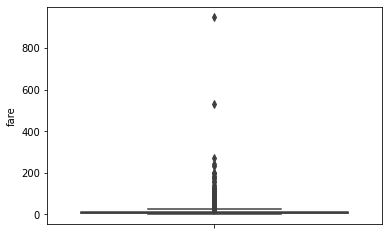

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(y='fare', data=df_baseline)
plt.show() # note o número de corrida com custo acima de 50 dólares

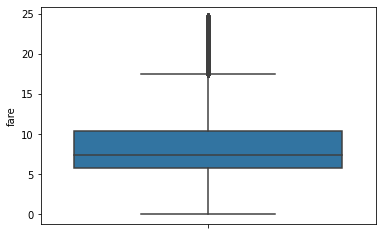

Limites: (-5.25; 24.75)
Tamanho do dataframe: (43055, 24)


In [11]:
# vamos ver agora quais são os limites de forma algébrica já que o gráfico não traz esse valor bem definido

Q1 = df_baseline['fare'].quantile(0.25)
Q3 = df_baseline['fare'].quantile(0.75)
IQ = Q3 - Q1
LI = Q1 - 1.5 * IQ
LS = Q3 + 1.5 * IQ

df_baseline_fare_sem_outliers = df_baseline[(df_baseline['fare'] > LI) & (df_baseline['fare'] < LS)]

sns.boxplot(y='fare', data=df_baseline_fare_sem_outliers)
plt.show()

print(f'Limites: ({LI}; {LS})')
print(f'Tamanho do dataframe: {df_baseline_fare_sem_outliers.shape}')

Esse processo de remoção é meio hardcoded mesmo, mas pra uma exploração incial, uma alternativa interessante pra economizar na repetição de código é fazer um loop pelas variáveis numéricas selecionadas. Algo meio assim:

In [12]:
df_baseline_sem_outiliers_variaveis = df_baseline.copy()

variaveis = ['trip_seconds', 'fare', 'trip_miles']

for variavel in variaveis:

  Q1 = df_baseline[variavel].quantile(0.25)
  Q3 = df_baseline[variavel].quantile(0.75)
  IQ = Q3 - Q1
  LI = Q1 - 1.5 * IQ
  LS = Q3 + 1.5 * IQ

  df_baseline_sem_outiliers_variaveis = df_baseline_sem_outiliers_variaveis[(df_baseline_sem_outiliers_variaveis[variavel] > LI) & (df_baseline_sem_outiliers_variaveis[variavel] < LS)]

print(f'Tamanho do dataframe: {df_baseline_sem_outiliers_variaveis.shape}')

Tamanho do dataframe: (41280, 24)


Veja que o dataframe com a remoção dos outiliers apena da variável fare ficou com 43055 linhas enquanto que no loop para remoção de várias colunas, ficamos com 41280, então deu certo. 

## 3. Codificação de variáveis categóricas

De forma geral, precisamos passar para os nossos modelos apenas valores numéricos. Por isso, vamos ver meios de transformar todas as variáveis que contnham strings em algo que só contenha números.

Pra fazer isso temos algumas alternativas:
1. Transformar cada categoria presente na variável em um número qualquer
2. Atribuir valores numericos às categorias com base em algum tipo de ordenação natural
3. Atribuir às categorias o valor da sua frequência
4. Atribuir valores relacionados à coluna alvo 
5. Criar colunas dummy para cada categoria presente

Pra esse tipo de transformação eu sugiro que nos apeguemos ao resultao e não às implementações. Pode ser que você encontre formais com as quais se sente mais confortável de chegar aos mesmos resultados e tudo bem. Eu vou mostrar formas com as quais eu lido bem, mas você pode encontrar as suas.

#### 3.1. Transformar cada categoria presente na variável em um número qualquer

In [13]:
from sklearn.preprocessing import LabelEncoder

df_baseline_company_encoded1 = df_baseline.copy()
df_baseline_company_encoded1.dropna(subset=['company'], inplace=True) # label encoder não aceita valores nulos. Qualquer método de imputação que a gente viu serve aqui.
le = LabelEncoder()

df_baseline_company_encoded1['company'] = le.fit_transform(df_baseline_company_encoded1['company'])
df_baseline_company_encoded1

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,ride_date
0,d3c594ba6b3eb5f9644b9af3f1328aa82744ffd5,a0ac953f8cee6f14d8f2f15bf14b52de5caab289f7d599...,2019-09-13 23:00:00+00:00,2019-09-13 23:00:00+00:00,60.0,0.0,NaN,NaN,7.0,7.0,3.25,0.00,0.0,0.0,3.25,Cash,104,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),2019-09-13
2,ab1adf76a077d31a82824264aed032f197423f5d,41afbb1073e9c58a6dbdfff8ad24160d01c862ca34c520...,2018-08-24 16:00:00+00:00,2018-08-24 16:45:00+00:00,3180.0,0.9,1.703198e+10,1.703108e+10,76.0,8.0,41.00,9.20,0.0,5.0,55.20,Credit Card,104,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.907413,-87.640902,POINT (-87.6409015248 41.9074128162),2018-08-24
4,48262d526cc41442f947b81a3ab0f60174fc66cc,11f73b08790612efe341cf8cf69cadbcb7732293794186...,2018-08-10 21:00:00+00:00,2018-08-10 21:00:00+00:00,600.0,1.6,1.703128e+10,1.703108e+10,28.0,8.0,7.50,1.50,0.0,0.0,9.00,Credit Card,77,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),2018-08-10
5,f5a6afb4daedb37b82500baf34cf41adcf7ca167,fcff47c0714c3d1a1ee9f6c36ea2854b938fadea98f2b5...,2013-03-01 19:15:00+00:00,2013-03-01 19:30:00+00:00,540.0,18.0,1.703108e+10,1.703108e+10,8.0,8.0,7.65,0.00,0.0,1.0,8.65,Cash,104,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),2013-03-01
6,7300fe06c7d01192943663f7cf939162619669be,986157590e289f9ab3cf4a79a671b85c251532d63a0ed1...,2017-02-06 15:30:00+00:00,2017-02-06 16:15:00+00:00,2280.0,24.3,1.703198e+10,NaN,76.0,NaN,58.25,16.00,0.0,33.0,107.25,Credit Card,90,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),NaN,NaN,NaN,2017-02-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,a3a6c9af9051d48af2b7b2fbdf02c962fa9a9ca9,cc33cdc1816a9ba9822dd033062f8d414cac183bbfa7fc...,2014-06-20 13:00:00+00:00,2014-06-20 13:00:00+00:00,515.0,1.6,1.703108e+10,1.703128e+10,8.0,28.0,7.25,2.00,NaN,1.0,10.25,Credit Card,61,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.879255,-87.642649,POINT (-87.642648998 41.8792550844),2014-06-20
49996,33b1fb15a4e0b417f8dcee508993db379abd0039,45bd8de07cb28a2d16874f8ba527f094fe8b68dceb5f59...,2014-06-30 14:30:00+00:00,2014-06-30 14:45:00+00:00,1140.0,1.0,NaN,NaN,69.0,69.0,10.45,0.00,0.0,1.0,11.45,Cash,77,41.763247,-87.616134,POINT (-87.6161341112 41.7632467988),41.763247,-87.616134,POINT (-87.6161341112 41.7632467988),2014-06-30
49997,cf5dbfda73e899b9889024b9ee51a97a4df72489,5c4dbf120a97d6d82d93388ef3ec44ea96fff151a5f179...,2014-09-20 01:45:00+00:00,2014-09-20 01:45:00+00:00,240.0,1.1,1.703183e+10,1.703107e+10,7.0,7.0,5.65,2.00,0.0,1.0,8.65,Credit Card,77,41.914747,-87.654007,POINT (-87.6540070286 41.9147473049),41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),2014-09-20
49998,dbac35b3e6a4ac99f8c691aaf885abc2f43cb4ca,6682944f2b37609761181033253037c05fed4377e8b649...,2019-07-23 16:00:00+00:00,2019-07-23 16:30:00+00:00,1500.0,0.0,NaN,NaN,32.0,15.0,25.75,0.00,0.0,5.0,30.75,Cash,99,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.954028,-87.763399,POINT (-87.7633990316 41.9540276487),2019-07-23


Dando uma olhada na coluna company depois da codificação, percebemos um 104 que quer dizer que temos ao menos 104 empresas. Na verdade são 111 companias de taxi nesse dataframe. se agruparmos por número de corridas, vemos que 65 dessas têm menos de 10 corridas no período. Tavez seja interessante primeiro categorizar todas que tem um número muito baixo como "outras" e depois fazer o label encoder pra enxugar um pouco essas categorias.

In [14]:
df_baseline_company_encoded1.dropna(subset=['company'], inplace=True)
df_baseline_company_encoded1.company.value_counts()[df_baseline_company_encoded1.company.value_counts() < 10] # filtrando as categorias com frequência menor que 10

12     9
41     7
19     7
3      7
28     7
      ..
44     1
39     1
106    1
42     1
109    1
Name: company, Length: 65, dtype: int64

Vamos ver com fazer assa categorização genérica pras empresas pouco representadas usando iterrows :

In [15]:
# também da pra fazer com list comprehensions, mas como nesse formato é necessário calcular o groupby pra todas as linhas do dataframe, leva perto de 5 minutos pra fazer a operação completa
# df_baseline_payment_encoded1 = df_baseline.copy()
# df_baseline_payment_encoded1.dropna(subset=['company'], inplace=True)

# df_baseline_payment_encoded1['company'] = [company if df_baseline_payment_encoded1['company'].value_counts()[df_baseline_payment_encoded1['company'].value_counts().index == company].values[0] >= 10 else
#                                            'outros' for company in df_baseline_payment_encoded1['company']]

In [16]:
df_baseline_company_encoded1 = df_baseline.copy()
df_baseline_company_encoded1.dropna(subset=['company'], inplace=True)

i = 0
agregado = df_baseline_company_encoded1.company.value_counts()[df_baseline_company_encoded1.company.value_counts() < 10].index

company_new = []
for index, row in df_baseline_company_encoded1.iterrows():
  if row['company'] in agregado:
    row['company'] = 'Outros'
    company_new.append('Outros')
  else:
    company_new.append(row['company'])
    pass

df_baseline_company_encoded1['company'] = company_new
df_baseline_company_encoded1.company.value_counts()

Taxi Affiliation Services                   10411
Flash Cab                                    4475
Dispatch Taxi Affiliation                    2714
Yellow Cab                                   2624
Blue Ribbon Taxi Association Inc.            2520
Chicago Carriage Cab Corp                    2091
Choice Taxi Association                      2001
Chicago Elite Cab Corp. (Chicago Carriag     1385
City Service                                 1380
Sun Taxi                                     1333
Medallion Leasin                             1172
Northwest Management LLC                      918
Taxi Affiliation Service Yellow               916
American United                               781
Star North Management LLC                     714
Globe Taxi                                    561
303 Taxi                                      497
KOAM Taxi Association                         460
Top Cab Affiliation                           426
Checker Taxi                                  380


https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6

#### 3.2. Atribuir valores numericos às categorias com base em algum tipo de ordenação natural

#### 3.3. Atribuir às categorias o valor da sua frequência

In [17]:
df_baseline_company_encoded3 = df_baseline.copy()
df_baseline_company_encoded3.dropna(subset=['company'], inplace=True)

frequencia_company = df_baseline_company_encoded3.groupby(by=['company'])['company'].count()

company_new = []
for index, row in df_baseline_company_encoded3.iterrows():
  company_new.append(frequencia_company.loc[row['company']])

df_baseline_company_encoded3['company'] = company_new
df_baseline_company_encoded3['company'].value_counts()

10411    10411
4475      4475
2714      2714
2624      2624
2520      2520
         ...  
5           20
6           18
18          18
11          11
9            9
Name: company, Length: 51, dtype: int64

#### 3.4. Atribuir valores relacionado à coluna alvo

Nesse nosso exemplo vou selecionar como valor mediano (pra tentar fugir um pouco do efeito de outliers) do preço da corrida como valor a ser codificado em cada empresa

Note que essa sintaxe usando .map pode ser usada pra fazer algumas das transformações dos tópicos anteriores 

In [18]:
df_baseline_company_encoded4 = df_baseline.copy()
df_baseline_company_encoded4.dropna(subset=['company'], inplace=True)
df_baseline_company_encoded4['company'] = df_baseline_company_encoded4['company'].map(df_baseline_company_encoded4.groupby(by='company')['fare'].median())
df_baseline_company_encoded4

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,ride_date
0,d3c594ba6b3eb5f9644b9af3f1328aa82744ffd5,a0ac953f8cee6f14d8f2f15bf14b52de5caab289f7d599...,2019-09-13 23:00:00+00:00,2019-09-13 23:00:00+00:00,60.0,0.0,NaN,NaN,7.0,7.0,3.25,0.00,0.0,0.0,3.25,Cash,8.00,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),2019-09-13
2,ab1adf76a077d31a82824264aed032f197423f5d,41afbb1073e9c58a6dbdfff8ad24160d01c862ca34c520...,2018-08-24 16:00:00+00:00,2018-08-24 16:45:00+00:00,3180.0,0.9,1.703198e+10,1.703108e+10,76.0,8.0,41.00,9.20,0.0,5.0,55.20,Credit Card,8.00,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.907413,-87.640902,POINT (-87.6409015248 41.9074128162),2018-08-24
4,48262d526cc41442f947b81a3ab0f60174fc66cc,11f73b08790612efe341cf8cf69cadbcb7732293794186...,2018-08-10 21:00:00+00:00,2018-08-10 21:00:00+00:00,600.0,1.6,1.703128e+10,1.703108e+10,28.0,8.0,7.50,1.50,0.0,0.0,9.00,Credit Card,8.25,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),2018-08-10
5,f5a6afb4daedb37b82500baf34cf41adcf7ca167,fcff47c0714c3d1a1ee9f6c36ea2854b938fadea98f2b5...,2013-03-01 19:15:00+00:00,2013-03-01 19:30:00+00:00,540.0,18.0,1.703108e+10,1.703108e+10,8.0,8.0,7.65,0.00,0.0,1.0,8.65,Cash,8.00,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),2013-03-01
6,7300fe06c7d01192943663f7cf939162619669be,986157590e289f9ab3cf4a79a671b85c251532d63a0ed1...,2017-02-06 15:30:00+00:00,2017-02-06 16:15:00+00:00,2280.0,24.3,1.703198e+10,NaN,76.0,NaN,58.25,16.00,0.0,33.0,107.25,Credit Card,7.85,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),NaN,NaN,NaN,2017-02-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,a3a6c9af9051d48af2b7b2fbdf02c962fa9a9ca9,cc33cdc1816a9ba9822dd033062f8d414cac183bbfa7fc...,2014-06-20 13:00:00+00:00,2014-06-20 13:00:00+00:00,515.0,1.6,1.703108e+10,1.703128e+10,8.0,28.0,7.25,2.00,NaN,1.0,10.25,Credit Card,8.25,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.879255,-87.642649,POINT (-87.642648998 41.8792550844),2014-06-20
49996,33b1fb15a4e0b417f8dcee508993db379abd0039,45bd8de07cb28a2d16874f8ba527f094fe8b68dceb5f59...,2014-06-30 14:30:00+00:00,2014-06-30 14:45:00+00:00,1140.0,1.0,NaN,NaN,69.0,69.0,10.45,0.00,0.0,1.0,11.45,Cash,8.25,41.763247,-87.616134,POINT (-87.6161341112 41.7632467988),41.763247,-87.616134,POINT (-87.6161341112 41.7632467988),2014-06-30
49997,cf5dbfda73e899b9889024b9ee51a97a4df72489,5c4dbf120a97d6d82d93388ef3ec44ea96fff151a5f179...,2014-09-20 01:45:00+00:00,2014-09-20 01:45:00+00:00,240.0,1.1,1.703183e+10,1.703107e+10,7.0,7.0,5.65,2.00,0.0,1.0,8.65,Credit Card,8.25,41.914747,-87.654007,POINT (-87.6540070286 41.9147473049),41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),2014-09-20
49998,dbac35b3e6a4ac99f8c691aaf885abc2f43cb4ca,6682944f2b37609761181033253037c05fed4377e8b649...,2019-07-23 16:00:00+00:00,2019-07-23 16:30:00+00:00,1500.0,0.0,NaN,NaN,32.0,15.0,25.75,0.00,0.0,5.0,30.75,Cash,8.00,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.954028,-87.763399,POINT (-87.7633990316 41.9540276487),2019-07-23


#### 3.5. Criar colunas dummy para cada categoria presente

O procedimento de criar colunas dummy consiste em criar uma matriz esparsa onde cada coluna é uma categoria na variável escolhida e as linhas são 1 para sim e zero para não. 
No nosso exemplo usando a coluna company sem alguma preparação prévia, teríamos nossa variavel distribuída em 111 colunas. 

Pra não ficar muito complicado de viasualizar, vamos usar aqui a variável payment_type pra fazer esse processo conhecido como one hot encoding

In [19]:
from sklearn.preprocessing import OneHotEncoder

df_baseline_company_encoded5 = df_baseline.copy()
df_baseline_company_encoded5.dropna(subset=['payment_type'], inplace=True)

ohe = OneHotEncoder()
payment_encoded_fit = ohe.fit(df_baseline_company_encoded5[['payment_type']])
payment_encoded = ohe.transform(df_baseline_company_encoded5[['payment_type']]).toarray()
payment_encoded_df = pd.DataFrame(payment_encoded)
payment_encoded_df

,0,1,2,3,4,5,6,7
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
49995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# pra ficar um pocuo mais legível
payment_encoded_fit.get_feature_names()

payment_encoded_df.columns = payment_encoded_fit.get_feature_names()
payment_encoded_df

,x0_Cash,x0_Credit Card,x0_Dispute,x0_Mobile,x0_No Charge,x0_Pcard,x0_Prcard,x0_Unknown
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
49995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Pra fechar, precisamos colar esse dataframe one hot ao nosso conjunto de dados e remover a coluna original

Também da pra tirar o x0_ do começo de cada tipo de pagamento, mas para o que a gente precisa já esta bom assim

In [21]:
df_baseline_company_encoded5.drop(columns=['payment_type'], inplace=True)
df_baseline_company_encoded5 = pd.concat([df_baseline_company_encoded5, payment_encoded_df], axis=1)
df_baseline_company_encoded5

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,ride_date,x0_Cash,x0_Credit Card,x0_Dispute,x0_Mobile,x0_No Charge,x0_Pcard,x0_Prcard,x0_Unknown
0,d3c594ba6b3eb5f9644b9af3f1328aa82744ffd5,a0ac953f8cee6f14d8f2f15bf14b52de5caab289f7d599...,2019-09-13 23:00:00+00:00,2019-09-13 23:00:00+00:00,60.0,0.0,NaN,NaN,7.0,7.0,3.25,0.00,0.0,0.0,3.25,Taxi Affiliation Services,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),2019-09-13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,cac1926e5b4ca977decbf9079ffd4b02cae90503,b5e2695a2f44b9bce7a0a86148ac418802f0067be1f6d4...,2014-06-19 18:00:00+00:00,2014-06-19 18:15:00+00:00,840.0,2.3,NaN,NaN,24.0,8.0,9.85,2.00,0.0,0.0,11.85,NaN,41.901207,-87.676356,POINT (-87.6763559892 41.90120699410001),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),2014-06-19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ab1adf76a077d31a82824264aed032f197423f5d,41afbb1073e9c58a6dbdfff8ad24160d01c862ca34c520...,2018-08-24 16:00:00+00:00,2018-08-24 16:45:00+00:00,3180.0,0.9,1.703198e+10,1.703108e+10,76.0,8.0,41.00,9.20,0.0,5.0,55.20,Taxi Affiliation Services,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.907413,-87.640902,POINT (-87.6409015248 41.9074128162),2018-08-24,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,d19b9b5131a749b6c8fee6661a84833421c1e25f,6daab772b2fe0e6dcb68884525d6ad9d44ce74ecaeb417...,2015-06-20 12:15:00+00:00,2015-06-20 12:30:00+00:00,540.0,2.9,1.703108e+10,1.703107e+10,8.0,7.0,9.44,2.00,0.0,0.0,11.44,NaN,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.929263,-87.635891,POINT (-87.6358909539 41.9292629902),2015-06-20,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,48262d526cc41442f947b81a3ab0f60174fc66cc,11f73b08790612efe341cf8cf69cadbcb7732293794186...,2018-08-10 21:00:00+00:00,2018-08-10 21:00:00+00:00,600.0,1.6,1.703128e+10,1.703108e+10,28.0,8.0,7.50,1.50,0.0,0.0,9.00,Choice Taxi Association,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),2018-08-10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,a3a6c9af9051d48af2b7b2fbdf02c962fa9a9ca9,cc33cdc1816a9ba9822dd033062f8d414cac183bbfa7fc...,2014-06-20 13:00:00+00:00,2014-06-20 13:00:00+00:00,515.0,1.6,1.703108e+10,1.703128e+10,8.0,28.0,7.25,2.00,NaN,1.0,10.25,American United,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.879255,-87.642649,POINT (-87.642648998 41.8792550844),2014-06-20,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,33b1fb15a4e0b417f8dcee508993db379abd0039,45bd8de07cb28a2d16874f8ba527f094fe8b68dceb5f59...,2014-06-30 14:30:00+00:00,2014-06-30 14:45:00+00:00,1140.0,1.0,NaN,NaN,69.0,69.0,10.45,0.00,0.0,1.0,11.45,Choice Taxi Association,41.763247,-87.616134,POINT (-87.6161341112 41.7632467988),41.763247,-87.616134,POINT (-87.6161341112 41.7632467988),2014-06-30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,cf5dbfda73e899b9889024b9ee51a97a4df72489,5c4dbf120a97d6d82d93388ef3ec44ea96fff151a5f179...,2014-09-20 01:45:00+00:00,2014-09-20 01:45:00+00:00,240.0,1.1,1.703183e+10,1.703107e+10,7.0,7.0,5.65,2.00,0.0,1.0,8.65,Choice Taxi Association,41.914747,-87.654007,POINT (-87.6540070286 41.9147473049),41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),2014-09-20,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,dbac35b3e6a4ac99f8c691aaf885abc2f43cb4ca,6682944f2b37609761181033253037c05fed4377e8b649...,2019-07-23 16:00:00+00:00,2019-07-23 16:30:00+00:00,1500.0,0.0,NaN,NaN,32.0,15.0,25.75,0.00,0.0,5.0,30.75,Star North Management LLC,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.954028,-87.763399,POINT (-87.7633990316 41.9540276487),2019-07-23,1.0,0.0,0.0,0.0,0

## 4. Como extrair informação implícita nas variáveis

Lá no primeiro notebook dessa análise das corridas de táxi, nós já tinhamos usado esse artifício pra ajudar a preencher alguns dados faltantes, mas vamos fazer de novo aqui só pra relembrar: podemos aproveitar que temos as coordenadas de latitude e longitute de início e final das corridas para calcular algo como uma distância padronizada já que o cálculo retorna a distância em linha reta e não o caminho percorrido.

In [22]:
import haversine as hs
from haversine import Unit

df_baseline_extracao_info = df_baseline.copy()
df_baseline_extracao_info.dropna(subset=['payment_type'], inplace=True)
df_baseline_extracao_info = pd.concat([df_baseline_extracao_info, payment_encoded_df], axis=1)

df_baseline_extracao_info['distancia_calculada'] = [hs.haversine((pickup_latitude, pickup_longitude), (dropoff_latitude, dropoff_longitude), unit=Unit.MILES) for pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
                             in zip(df_baseline_extracao_info['pickup_longitude'], df_baseline_extracao_info['pickup_latitude'], df_baseline_extracao_info['dropoff_longitude'], df_baseline_extracao_info['dropoff_latitude'])]  

df_baseline_extracao_info['distancia_calculada']

0         0.000000
1         2.216590
2        14.352838
3         2.587820
4         1.043236
           ...    
49995     1.464978
49996     0.000000
49997     0.997686
49998     8.801185
49999    15.458278
Name: distancia_calculada, Length: 50000, dtype: float64

Outras informações novas podem ser, por exemplo, duração da corrida, dia da semana, dia do mês, mês e ano

## 5. Como encotrar informação externa ao nosso dataset

Será que as informações de clima no dia da corrida têm alguma relação com o custo? Felizmente não é muito complicado econtrar dados abertos com esse tipo de registro

In [23]:
import numpy as np
from datetime import datetime
from datetime import timedelta

colunas = ['ID', 'Year', 'DOY', 'UTC', 'AirTemp', 'WindSpd', 'WindGst', 'WindDir', 'RelHum']

dataframe_clima = pd.DataFrame(columns=colunas)

for ano in np.arange(2012, 2020, 1):
  url = f'https://www.glerl.noaa.gov/metdata/chi/archive/chi{ano}.04t.txt'
  clima = pd.read_csv(url)
  
  id = []
  year = []
  doy = []
  utc = []
  airtemp = []
  windspd = []
  windgst = []
  winddir = []
  relhum = []

  for idx in range(clima.shape[0]):
    array_certo = []
    array_todo_torto = clima.loc[idx].values[0].split(' ')

    for element in array_todo_torto:
      if element == '':
        pass
      else:
        array_certo.append(element)
    
    if array_certo[1] == 'Year':
      continue

    if len(array_certo) == 9:
      id.append(array_certo[0])
      year.append(array_certo[1])
      doy.append(array_certo[2])
      utc.append(array_certo[3])
      airtemp.append(array_certo[4])
      windspd.append(array_certo[5])
      windgst.append(array_certo[6])
      winddir.append(array_certo[7])
      relhum.append(array_certo[8])
    
    if len(array_certo) == 8 and ano < 2015:
      id.append(array_certo[0])
      year.append(array_certo[1])
      doy.append(array_certo[2])
      utc.append(array_certo[3])
      airtemp.append(array_certo[4])
      windspd.append(array_certo[5])
      windgst.append(array_certo[6])
      winddir.append(array_certo[7])
      relhum.append(0)
  
  parcial = pd.DataFrame({
    'ID': id,
    'Year': year,
    'DOY': doy,
    'UTC': utc,
    'AirTemp': airtemp,
    'WindSpd': windspd,
    'WindGst': windgst,
    'WindDir': winddir,
    'RelHum': relhum
  })

  dataframe_clima = pd.concat([dataframe_clima, parcial.loc[1:]])
  dataframe_clima['Year'] = dataframe_clima['Year'].astype('int')
  dataframe_clima['DOY'] = dataframe_clima['DOY'].astype('int')
  dataframe_clima['AirTemp'] = dataframe_clima['AirTemp'].astype('float')
  dataframe_clima['WindSpd'] = dataframe_clima['WindSpd'].astype('float')
  dataframe_clima['WindGst'] = dataframe_clima['WindGst'].astype('float')
  dataframe_clima['WindDir'] = dataframe_clima['WindDir'].astype('int')
  dataframe_clima['RelHum'] = dataframe_clima['RelHum'].astype('float')

  print(ano, dataframe_clima.shape[0], parcial.shape[0])


dataframe_clima.reset_index(drop=True, inplace=True)

dataframe_clima['timestamp'] = [datetime(year,1,1) + timedelta(days=doy) + timedelta(hours=int(utc[:2]) - 6) for year, doy, utc in
                                zip(dataframe_clima['Year'], dataframe_clima['DOY'], dataframe_clima['UTC'])]

dataframe_clima_to_merge = dataframe_clima.groupby(by=['timestamp']).median().reset_index()
dataframe_clima_to_merge

2012 105631 105632
2013 210739 105109
2014 315449 104711
2015 330631 15183
2016 594183 263553
2017 856528 262346
2018 1114691 258164
2019 1377331 262641


,timestamp,Year,DOY,AirTemp,WindSpd,WindGst,WindDir,RelHum
0,2012-01-01 17:00:00,2011.0,365.0,2.850,12.680,15.970,173.0,0.00
1,2012-01-01 18:00:00,2012.0,1.0,2.955,12.660,15.535,170.0,0.00
2,2012-01-01 19:00:00,2012.0,1.0,3.120,13.975,16.315,170.0,0.00
3,2012-01-01 20:00:00,2012.0,1.0,3.345,14.225,16.465,170.5,0.00
4,2012-01-01 21:00:00,2012.0,1.0,3.955,11.230,12.840,174.5,0.00
...,...,...,...,...,...,...,...,...
61687,2020-01-01 13:00:00,2019.0,365.0,-2.600,9.900,11.700,273.0,77.85
61688,2020-01-01 14:00:00,2019.0,365.0,-2.500,10.400,12.150,267.0,78.35
61689,2020-01-01 15:00:00,2019.0,365.0,-2.500,10.300,11.500,261.5,78.00
61690,2020-01-01 16:00:00,2019.0,365.0,-2.300,9.600,11.300,261.5,77.05


Aqui, eu tentei simplificar ao máximo o processo dentro de uma única celula já que temos alguns loops encadeados. No final das contas, temos um dataframe com informações agrupadas por data e de hora em hora dentro de cada dia no intervalo do começo de 2012 até o final de 2019. Os dados de 2020 por ainda ser o ano corrente enquanto eu escrevo, esão em uma url um pouquinho diferente, então vamos fazer na próxima célula e depois juntar os dois com mais um concat.

In [24]:
colunas = ['ID', 'Year', 'DOY', 'UTC', 'AirTemp', 'WindSpd', 'WindGst', 'WindDir', 'RelHum']

dataframe_clima_2020 = pd.DataFrame(columns=colunas)

for i in range(366):

  date = (datetime(2020,1,1) + timedelta(i)).strftime('%Y%m%d')
  url = f'https://www.glerl.noaa.gov/metdata/chi/2020/{date}.04t.txt'
  clima = pd.read_csv(url)

  id = []
  year = []
  doy = []
  utc = []
  airtemp = []
  windspd = []
  windgst = []
  winddir = []
  relhum = []



  for idx in range(clima.shape[0]):
    array_certo = []
    array_todo_torto = clima.loc[idx].values[0].split(' ')

    for element in array_todo_torto:
      if element == '':
        pass
      else:
        array_certo.append(element)
    
    if len(array_certo) == 9:
      id.append(array_certo[0])
      year.append(array_certo[1])
      doy.append(array_certo[2])
      utc.append(array_certo[3])
      airtemp.append(array_certo[4])
      windspd.append(array_certo[5])
      windgst.append(array_certo[6])
      winddir.append(array_certo[7])
      relhum.append(array_certo[8])

  temp = pd.DataFrame({
    'ID': id,
    'Year': year,
    'DOY': doy,
    'UTC': utc,
    'AirTemp': airtemp,
    'WindSpd': windspd,
    'WindGst': windgst,
    'WindDir': winddir,
    'RelHum': relhum
  })

  dataframe_clima_2020 = pd.concat([dataframe_clima_2020, temp.loc[1:]])

  if str((datetime(2020,1,1) + timedelta(i + 1)).date()) == str(datetime.today().date()):
    break
  # print(date) # usei esse print pra ter controle das saidas do loop, é uma boa prática usar esse tipo de verbosidade pra debugar processos iterativos 

dataframe_clima_2020.reset_index(drop=True, inplace=True)

dataframe_clima_2020['Year'] = dataframe_clima_2020['Year'].astype('int')
dataframe_clima_2020['DOY'] = dataframe_clima_2020['DOY'].astype('int')
dataframe_clima_2020['AirTemp'] = dataframe_clima_2020['AirTemp'].astype('float')
dataframe_clima_2020['WindSpd'] = dataframe_clima_2020['WindSpd'].astype('float')
dataframe_clima_2020['WindGst'] = dataframe_clima_2020['WindGst'].astype('float')
dataframe_clima_2020['WindDir'] = dataframe_clima_2020['WindDir'].astype('int')
dataframe_clima_2020['RelHum'] = dataframe_clima_2020['RelHum'].astype('float')

dataframe_clima_2020['timestamp'] = [datetime(year,1,1) + timedelta(days=doy) + timedelta(hours=int(utc[:2]) - 6) for year, doy, utc in
                                zip(dataframe_clima_2020['Year'], dataframe_clima_2020['DOY'], dataframe_clima_2020['UTC'])]

dataframe_clima_2020_to_merge = dataframe_clima_2020.groupby(by=['timestamp']).median().reset_index()
dataframe_clima_2020_to_merge

,timestamp,Year,DOY,AirTemp,WindSpd,WindGst,WindDir,RelHum
0,2020-01-01 17:00:00,2019.0,365.0,-1.70,9.70,12.10,264.0,79.80
1,2020-01-01 18:00:00,2020.0,1.0,-1.65,10.90,12.75,265.0,80.30
2,2020-01-01 19:00:00,2020.0,1.0,-1.50,10.40,12.00,272.0,81.90
3,2020-01-01 20:00:00,2020.0,1.0,-1.50,9.95,11.55,270.0,82.80
4,2020-01-01 21:00:00,2020.0,1.0,-1.50,8.95,10.50,264.0,85.10
...,...,...,...,...,...,...,...,...
8636,2020-12-26 13:00:00,2020.0,360.0,-7.00,8.75,9.90,261.0,56.40
8637,2020-12-26 14:00:00,2020.0,360.0,-6.60,8.80,10.30,263.5,59.95
8638,2020-12-26 15:00:00,2020.0,360.0,-6.10,9.20,10.80,258.0,57.15
8639,2020-12-26 16:00:00,2020.0,360.0,-5.65,9.75,11.30,253.0,57.80


Os processos foram um pouquinho diferentes, mas obtivemos dados com uma mesma estrutura pra poder fazer a união com o outro dataframe de clima e depois com o nosso dataframe das corridas

In [25]:
dataframe_clima_completo = pd.concat([dataframe_clima_to_merge, dataframe_clima_2020_to_merge]).reset_index(drop=True)
dataframe_clima_completo

,timestamp,Year,DOY,AirTemp,WindSpd,WindGst,WindDir,RelHum
0,2012-01-01 17:00:00,2011.0,365.0,2.850,12.680,15.970,173.0,0.00
1,2012-01-01 18:00:00,2012.0,1.0,2.955,12.660,15.535,170.0,0.00
2,2012-01-01 19:00:00,2012.0,1.0,3.120,13.975,16.315,170.0,0.00
3,2012-01-01 20:00:00,2012.0,1.0,3.345,14.225,16.465,170.5,0.00
4,2012-01-01 21:00:00,2012.0,1.0,3.955,11.230,12.840,174.5,0.00
...,...,...,...,...,...,...,...,...
70328,2020-12-26 13:00:00,2020.0,360.0,-7.000,8.750,9.900,261.0,56.40
70329,2020-12-26 14:00:00,2020.0,360.0,-6.600,8.800,10.300,263.5,59.95
70330,2020-12-26 15:00:00,2020.0,360.0,-6.100,9.200,10.800,258.0,57.15
70331,2020-12-26 16:00:00,2020.0,360.0,-5.650,9.750,11.300,253.0,57.80


## 6. Como avaliar se uma variável tem relação com o valor a ser previsto

Também ja demos uma olhada, lá na primeira parte, num método muito prático dos dataframes para construir uma matriz de correlação. Aqui vou apenas adicionar umas duas ou três linhas de código opcionais pra ter uma visualização um pouco melhor

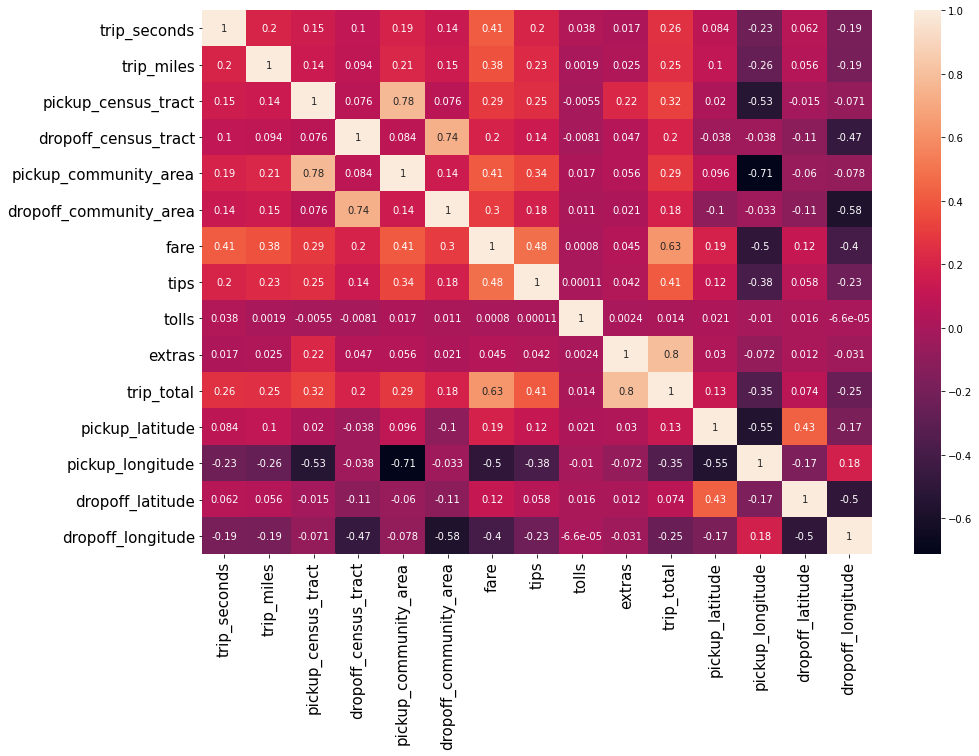

In [26]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_baseline.corr(), annot=True, annot_kws={'fontsize': 10})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

O importante aqui são os extremos. Estamos procurando valores que tendam muito ao branco ou ao preto pois esses são os maiores valores pra correlação positiva ou negativa entre as variáveis no cruzamento, em especial nos cruzamentos com a coluna fare

Como eu só plotei os as correlações do dataframe original, vamos fazer aqui a adição de algumas das variáveis criadas com os métodos anteriores. Pra simplificar as uniões, vou utilizar os dataframe limpo de valores nulos

In [27]:
from datetime import datetime
from datetime import timedelta
import calendar

df_baseline_limpo_novas_features = df_baseline.dropna().copy()

df_baseline_limpo_novas_features['distancia_calculada_km'] = [hs.haversine((pickup_latitude, pickup_longitude), (dropoff_latitude, dropoff_longitude), unit=Unit.KILOMETERS) for
                                                           pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude in
                                                           zip(df_baseline_limpo_novas_features['pickup_longitude'], df_baseline_limpo_novas_features['pickup_latitude'],
                                                               df_baseline_limpo_novas_features['dropoff_longitude'], df_baseline_limpo_novas_features['dropoff_latitude'])] 

df_baseline_limpo_novas_features['trip_start_timestamp_local'] = [datetime.strptime(timestamp.split('+')[0], '%Y-%m-%d %H:%M:%S') - timedelta(hours=6) for timestamp in
                                                                  df_baseline_limpo_novas_features['trip_start_timestamp']] # chicago fica a -6 de gmt0

df_baseline_limpo_novas_features['trip_start_date_local'] = [timestamp_local.date() for timestamp_local in df_baseline_limpo_novas_features['trip_start_timestamp_local']]
df_baseline_limpo_novas_features['trip_start_hour_local'] = [timestamp_local.time().hour for timestamp_local in df_baseline_limpo_novas_features['trip_start_timestamp_local']]
df_baseline_limpo_novas_features['trip_start_weekday'] = [timestamp_local.weekday() for timestamp_local in df_baseline_limpo_novas_features['trip_start_timestamp_local']] # domingo == 0

df_baseline_limpo_novas_features['trip_end_timestamp_local'] = [datetime.strptime(timestamp.split('+')[0], '%Y-%m-%d %H:%M:%S') - timedelta(hours=6) for timestamp in df_baseline_limpo_novas_features['trip_end_timestamp']]
df_baseline_limpo_novas_features['duracao_calculada_minutos'] = [(trip_end_timestamp_local - trip_start_timestamp_local).seconds / 60 for trip_end_timestamp_local, trip_start_timestamp_local in
                                                                 zip(df_baseline_limpo_novas_features['trip_end_timestamp_local'], df_baseline_limpo_novas_features['trip_start_timestamp_local'])]

df_baseline_limpo_novas_features['velocidade_media_km_hour'] = (df_baseline_limpo_novas_features['distancia_calculada_km'] /
                                                                (df_baseline_limpo_novas_features['duracao_calculada_minutos'] / 60)) # vai dar problema com corridas com tempo 0, mas depois a gente vê isso

df_baseline_limpo_novas_features['trip_start_timestamp_to_merge'] = [datetime(date_local.year, date_local.month, date_local.day, hour_local) for date_local, hour_local in
                                                                     zip(df_baseline_limpo_novas_features['trip_start_date_local'], df_baseline_limpo_novas_features['trip_start_hour_local'])]

df_baseline_limpo_novas_features = pd.merge(df_baseline_limpo_novas_features, dataframe_clima_completo, left_on='trip_start_timestamp_to_merge', right_on='timestamp', how='left')
df_baseline_limpo_novas_features

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,ride_date,distancia_calculada_km,trip_start_timestamp_local,trip_start_date_local,trip_start_hour_local,trip_start_weekday,trip_end_timestamp_local,duracao_calculada_minutos,velocidade_media_km_hour,trip_start_timestamp_to_merge,timestamp,Year,DOY,AirTemp,WindSpd,WindGst,WindDir,RelHum
0,ab1adf76a077d31a82824264aed032f197423f5d,41afbb1073e9c58a6dbdfff8ad24160d01c862ca34c520...,2018-08-24 16:00:00+00:00,2018-08-24 16:45:00+00:00,3180.0,0.9,1.703198e+10,1.703108e+10,76.0,8.0,41.00,9.2,0.0,5.0,55.20,Credit Card,Taxi Affiliation Services,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.907413,-87.640902,POINT (-87.6409015248 41.9074128162),2018-08-24,23.098654,2018-08-24 10:00:00,2018-08-24,10,4,2018-08-24 10:45:00,45.0,30.798205,2018-08-24 10:00:00,2018-08-24 10:00:00,2018.0,235.0,23.700,4.800,5.700,224.5,40.70
1,48262d526cc41442f947b81a3ab0f60174fc66cc,11f73b08790612efe341cf8cf69cadbcb7732293794186...,2018-08-10 21:00:00+00:00,2018-08-10 21:00:00+00:00,600.0,1.6,1.703128e+10,1.703108e+10,28.0,8.0,7.50,1.5,0.0,0.0,9.00,Credit Card,Choice Taxi Association,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),2018-08-10,1.678926,2018-08-10 15:00:00,2018-08-10,15,4,2018-08-10 15:00:00,0.0,inf,2018-08-10 15:00:00,2018-08-10 15:00:00,2018.0,221.0,30.800,7.650,8.600,267.5,51.95
2,f5a6afb4daedb37b82500baf34cf41adcf7ca167,fcff47c0714c3d1a1ee9f6c36ea2854b938fadea98f2b5...,2013-03-01 19:15:00+00:00,2013-03-01 19:30:00+00:00,540.0,18.0,1.703108e+10,1.703108e+10,8.0,8.0,7.65,0.0,0.0,1.0,8.65,Cash,Taxi Affiliation Services,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),2013-03-01,1.843962,2013-03-01 13:15:00,2013-03-01,13,4,2013-03-01 13:30:00,15.0,7.375846,2013-03-01 13:00:00,2013-03-01 13:00:00,2013.0,59.0,0.170,13.725,15.925,346.0,0.00
3,8c7eb6c919ccc5197f9f97255f3eb5cd8ab6a0b1,07588fc5119d1c29249afc3e41417094185f808c12ff3d...,2013-02-22 21:15:00+00:00,2013-02-22 21:30:00+00:00,840.0,0.0,1.703106e+10,1.703103e+10,6.0,77.0,10.25,0.0,0.0,0.0,10.25,Cash,Northwest Management LLC,41.938391,-87.638575,POINT (-87.6385749205 41.938391257700005),41.978875,-87.657871,POINT (-87.6578712629 41.9788750584),2013-02-22,4.776007,2013-02-22 15:15:00,2013-02-22,15,4,2013-02-22 15:30:00,15.0,19.104028,2013-02-22 15:00:00,2013-02-22 15:00:00,2013.0,52.0,-3.665,8.875,10.240,87.0,0.00
4,f06a3db639297271c4a1f5b3704d5c0790d62620,1c87f263c28aad874e0931b598767aeab2dbb7bbdb89d5...,2018-02-23 13:15:00+00:00,2018-02-23 13:30:00+00:00,1020.0,4.2,1.703184e+10,1.703108e+10,33.0,8.0,14.00,2.0,0.0,0.0,16.00,Credit Card,Choice Taxi Association,41.849247,-87.624135,POINT (-87.6241352979 41.84924675450001),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),2018-02-23,5.465153,2018-02-23 07:15:00,2018-02-23,7,4,2018-02-23 07:30:00,15.0,21.860612,2018-02-23 07:00:00,2018-02-23 07:00:00,2018.0,53.0,1.000,8.250,9.050,63.5,85.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21633,67d56b52bde3b66d747f7b45dfab4b73431e2c2d,af3b4b23f34495cb17ffb1b5ba884c08a6266690661eb2...,2018-03-14 17:15:00+00:00,2018-03-14 17:30:00+00:00,180.0,0.5,1.703184e+10,1.703108e+10,32.0,8.0,4.75,2.0,0.0,0.0,6.75,Credit Card,Star North Management LLC,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),2018-03-14,1.230617,2018-03-14 11:15:00,2018-03-14,11,2,2018-03-14 11:30:00,15.0,4.922466,2018-03-14 11:00:00,2018-03-14 11:00:00,2018.0,72.0,-0.800,10.100,11.10